In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

In [1]:
from datasets import load_dataset

ds = load_dataset("mattmdjaga/human_parsing_dataset")

/opt/miniconda3/envs/dataset/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 17706
    })
})

In [36]:
# ds['train']['image'][0]
mask = ds['train']['mask'][0]

In [37]:
np.unique(mask)

array([ 0,  2,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16], dtype=uint8)

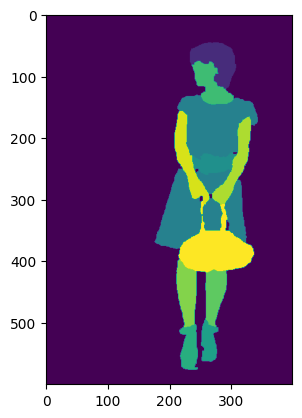

In [79]:
plt.imshow(mask)

In [50]:
class_mapping = {
    0: 0,
    4: 1,
    5: 2,
    6: 2,
    7: 3,
}
ignore_classes = {1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}

# Encode

In [88]:
def rle_encoding(mask: np.ndarray) -> str:
    """
    Converts a mask into run-length encoding (RLE) format using vectorized operations.

    Args:
        mask (`np.ndarray`): The mask where each pixel value represents the class ID.

    Returns:
        `str`: The RLE string.
    """
    pixels = mask.T.flatten()  # Transpose to switch to column-major order
    flat_pixels = np.r_[-1, pixels, -1]  # Add sentinel values for easier run detection
    runs = np.diff(np.where(flat_pixels != np.roll(flat_pixels, 1))[0])
    start_positions = np.where(flat_pixels[1:] != flat_pixels[:-1])[0] + 1

    run_lengths = runs[1::2]
    starts = start_positions[1::2] + 1

    encoded_rle = ' '.join(f"{start} {length}" for start, length in zip(starts, run_lengths))

    return encoded_rle



def create_train_csv(dataset, output_csv: str, class_mapping: dict, ignore_classes: set):
    """
    Creates a train.csv file with the columns ImageId, EncodedPixels, Height, Width, and ClassId.

    Args:
        dataset (`DatasetDict`): The Hugging Face DatasetDict object containing the dataset.
        output_csv (`str`): The path to the output CSV file.
        class_mapping (`dict`): A dictionary mapping original class IDs to new class IDs.
        ignore_classes (`set`): A set of class IDs to be ignored.
    """
    records = []

    for index, item in tqdm(enumerate(dataset['train']), total=len(dataset['train'])):
        image = np.array(item['mask'])
        height, width = image.shape
        image_id = f"image_{index}"  # Generate a unique name for each image

        # Initialize masks for each new class ID
        masks = {new_class_id: np.zeros((height, width), dtype=np.uint8) for new_class_id in class_mapping.values()}
        
        for original_class_id in range(18):
            if original_class_id in ignore_classes:
                continue

            new_class_id = class_mapping.get(original_class_id, original_class_id)
            if new_class_id not in masks:
                continue

            class_mask = (image == original_class_id).astype(np.uint8)
            masks[new_class_id] += class_mask

        for new_class_id, combined_mask in masks.items():
            if combined_mask.sum() > 0:
                encoded_pixels = rle_encoding(combined_mask)
                records.append({
                    "ImageId": image_id,
                    "EncodedPixels": encoded_pixels,
                    "Height": height,
                    "Width": width,
                    "ClassId": new_class_id
                })
        if index > 1:
            break
        

    df = pd.DataFrame(records, columns=["ImageId", "EncodedPixels", "Height", "Width", "ClassId"])
    df.to_csv(output_csv, index=False)
    return df



In [89]:
df_atr = create_train_csv(ds, "train.csv", class_mapping, ignore_classes)

  0%|          | 2/17706 [00:00<02:01, 146.24it/s]


# Decode

In [2]:
import pandas as pd

In [90]:
# df = pd.read_csv("/Users/saagarparikh/Downloads/imaterialist/train.csv")
df1 = pd.read_csv("train.csv")

In [93]:
df1.value_counts('ImageId')

ImageId
image_12999    4
image_8400     4
image_13478    4
image_12383    4
image_8028     4
              ..
image_5990     2
image_5993     2
image_5994     2
image_13446    2
image_0        2
Name: count, Length: 17706, dtype: int64

In [84]:
import pandas as pd
import numpy as np
from PIL import Image

def decode_rle(rle, shape):
    s = list(map(int, rle.split()))
    starts, lengths = s[0::2], s[1::2]
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for start, length in zip(starts, lengths):
        start -= 1  # Convert from 1-based to 0-based indexing
        img[start:start + length] = 1
    return img.reshape((shape[1], shape[0])).T

def create_mask_images(df, output_dir):
    for image_id in df['ImageId'].unique():
        image_df = df[df['ImageId'] == image_id]
        height, width = image_df.iloc[0][['Height', 'Width']].astype(int)
        mask = np.zeros((height, width), dtype=np.uint8)
        for _, row in image_df.iterrows():
            class_id = row['ClassId']
            rle = row['EncodedPixels']
            class_mask = decode_rle(rle, (height, width))
            mask[class_mask == 1] = class_id
        Image.fromarray(mask).save(f"{output_dir}/{image_id}.png")

In [85]:
import os
os.makedirs("out_masks_atr", exist_ok=True)
create_mask_images(df1, "out_masks_atr")

In [86]:
temp = np.array(Image.open("out_masks_atr/image_0.png"))

(array([0, 3], dtype=uint8), <matplotlib.image.AxesImage at 0x80944b3d0>)

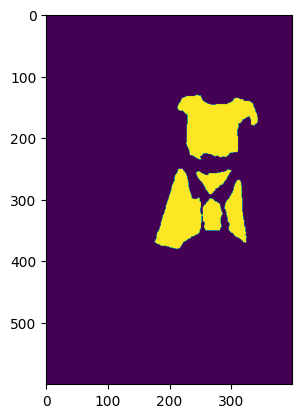

In [87]:
np.unique(temp), plt.imshow(temp)

# Save images

In [95]:
import os
import numpy as np
from PIL import Image

def save_images_and_masks(dataset, image_dir: str = "images", mask_dir: str = "masks"):
    os.makedirs(image_dir, exist_ok=True)
    # os.makedirs(mask_dir, exist_ok=True)
    
    for index, item in tqdm(enumerate(dataset['train']), total=len(dataset)):
        image = item['image']
        # mask = item['mask']

        image_path = os.path.join(image_dir, f"image_{index}.png")
        # mask_path = os.path.join(mask_dir, f"mask_{index}.png")

        image.save(image_path)
        # mask.save(mask_path)



In [ ]:
save_images_and_masks(ds, "train")